In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from dateutil.relativedelta import relativedelta
import nltk
import spacy
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import pos_tag
import re
from wordsegment import load, segment
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from spellchecker import SpellChecker
import matplotlib.pyplot as plt

In [2]:
dataset = pd.read_csv('Energy-Data.csv')

In [3]:
# Previewing the dataset
dataset.head()

,Company,Reviewer Verification Status,Date,Rating,Review
0,British Gas,Verified Reviewer,Posted 18 hours ago,1,“\nSince opening an account after my husband d...
1,British Gas,NaN,Posted 1 day ago,1,"“\nBritish Gas, if you going to launch a new a..."
2,British Gas,NaN,Posted 1 day ago,1,“\nReceived a letter saying we were £1800 in c...
3,British Gas,NaN,Posted 1 day ago,1,“\nI received a letter on 17 November saying m...
4,British Gas,Verified Reviewer,Posted 1 day ago,1,“\nI submitted my meter readings for this mont...


In [4]:
# Filling the verification status
dataset['Reviewer Verification Status'].fillna('Not Verified', inplace=True)

In [5]:
# The date the dataset was collected
date_of_date_collection = '01-12-2023'

In [6]:
# Removing the Posted string
dataset['Date'] = dataset['Date'].str.strip('Posted ').str.strip(' ag')

In [7]:
def get_actual_date(value):
    try:
        number, period = value.split()
        number = int(number)

        date = dt.datetime.strptime(date_of_date_collection, '%d-%m-%Y')
        if 'day' in period:
            time_period = date - relativedelta(days=number)
        elif 'week' in period :
            time_period = date - relativedelta(weeks=number)
        elif 'month' in period:
            time_period = date - relativedelta(months=number)
        elif 'year' in period:
            time_period = date - relativedelta(years=number)
        elif 'hour' in period:
            time_period = date - relativedelta(hours=number)
        else:
            time_period = None
    except: 
        time_period = None
    
    return time_period

In [8]:
# Creating approximate date of reviews
dataset['Approximate Date of Review'] = dataset['Date'].apply(get_actual_date)

In [9]:
# previewing the changes
dataset.head()

,Company,Reviewer Verification Status,Date,Rating,Review,Approximate Date of Review
0,British Gas,Verified Reviewer,18 hours,1,“\nSince opening an account after my husband d...,2023-11-30 06:00:00
1,British Gas,Not Verified,1 day,1,"“\nBritish Gas, if you going to launch a new a...",2023-11-30 00:00:00
2,British Gas,Not Verified,1 day,1,“\nReceived a letter saying we were £1800 in c...,2023-11-30 00:00:00
3,British Gas,Not Verified,1 day,1,“\nI received a letter on 17 November saying m...,2023-11-30 00:00:00
4,British Gas,Verified Reviewer,1 day,1,“\nI submitted my meter readings for this mont...,2023-11-30 00:00:00


In [10]:
# Getting the info of the dataset
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4153 entries, 0 to 4152
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Company                       4153 non-null   object        
 1   Reviewer Verification Status  4153 non-null   object        
 2   Date                          4153 non-null   object        
 3   Rating                        4153 non-null   int64         
 4   Review                        4153 non-null   object        
 5   Approximate Date of Review    4153 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 194.8+ KB


In [11]:
# Removing the null values
dataset.dropna(inplace=True)

### Text Preparation

In [12]:
# Removing non alphabetical words
dataset['Review'] = dataset['Review'].apply(lambda m: re.sub('[^A-Za-z ]', '', m.lower())).str.replace('\n', ' ').str.strip()

dataset['Review'] = dataset['Review'].apply(lambda x: re.sub('\s{2,}', ' ', x))

In [13]:
# This is used for correcting the texts
spelling = SpellChecker()
load() 

# Some text contains adjoined words and incorrectly spelt words
def segment_spell_text(text):
    "This function will correct cojoined and incorrectly spelt words"
    corpus = []
    text = text.split()
    
    for wrd in text:
        if len(wrd) >= 4 and spelling.correction(wrd) is None: 
        # This makes it significantly faster as it ensures that only words that are 3 letters and above are considered
            clean = segment(wrd)
        else:
            clean = [spelling.correction(wrd)]
        
        corpus.extend(clean)
    return " ".join(corpus)

dataset['Review'] = dataset['Review'].apply(lambda x: segment_spell_text(x))

In [14]:
# create preprocess_text function
def preprocess_text(text):
    spacy_lemma = spacy.load("en_core_web_sm") # using the spacy module
    
    # Tokenize and lemmatize the text with spacy
    tokens = [wrd.lemma_ for wrd in spacy_lemma(text)]
    
    # Creating more stop words
    stop_words = ['british', 'gas', 'octopus', 'eon', 'npower', 'get', 'edf', 'energy', 'bg'] + stopwords.words('english')

    # Remove stop words
    filtered_tokens = [token for token in tokens if token not in stop_words and len(token) > 1 and 'http' not in token]

    # Join the tokens back into a string
    processed_text = ' '.join(filtered_tokens)
    return processed_text

# Applying the preprocessing function
dataset['Review_Text_Cleaned'] = dataset['Review'].apply(preprocess_text)

### Sentiment Analysis 

In [15]:
# Using the Vader Sentiment Analyser
sia = SentimentIntensityAnalyzer()

In [16]:
# Function to get sentiment of text
def get_sentiment(compound):
    if compound < 0:
        return "Negative"
    elif compound == 0:
        return "Neutral"
    else:
        return 'Positive'

In [17]:
# Getting the sentiment of the review
dataset['Sentiment'] = dataset['Review_Text_Cleaned'].apply(lambda word: get_sentiment(sia.polarity_scores(word)['compound']))

In [19]:
# Previewing the sentiment
dataset.head()

,Company,Reviewer Verification Status,Date,Rating,Review,Approximate Date of Review,Review_Text_Cleaned,Sentiment
0,British Gas,Verified Reviewer,18 hours,1,since opening an account after my husband died...,2023-11-30 06:00:00,since open account husband die unable open lin...,Negative
1,British Gas,Not Verified,1 day,1,british gas if you going to launch a new app w...,2023-11-30 00:00:00,go launch new app come product awful interface...,Negative
2,British Gas,Not Verified,1 day,1,received a letter saying we were in credit the...,2023-11-30 00:00:00,receive letter say credit receive one say owe ...,Positive
3,British Gas,Not Verified,1 day,1,i received a letter on november saying my ac n...,2023-11-30 00:00:00,receive letter november say ac change mention ...,Negative
4,British Gas,Verified Reviewer,1 day,1,i submitted my meter readings for this month a...,2023-11-30 00:00:00,submit meter reading month every month next da...,Positive


### Validating Sentiments
To confirm the sentiment, I'll cross check the rating along with the sentiment to see if neutral sentiments match. This is done on the premise that if a rating is given as 1, then the sentiment cannot be neutral.

In [20]:
# Incorrect positive sentiments
incorrect_sents = dataset[(dataset['Rating'] == 1) & (dataset['Sentiment'] == 'Positive')]

# Viewing the rating and sentiment values
incorrect_sentiments = dataset[(dataset['Rating'] == 1) & (dataset['Sentiment'] == 'Neutral')]

After reading through the corpus, one could argue that the model got it wrong in assigning a neutral sentiment to the text. Hence, I'll reassign the values to Negative

In [22]:
# Reassigning the sentiments to negative
dataset['Sentiment'].loc[incorrect_sentiments.index] = 'Negative'
dataset['Sentiment'].loc[incorrect_sents.index] = 'Negative'

C:\Users\USER\AppData\Local\Temp\ipykernel_13560\291315767.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Sentiment'].loc[incorrect_sentiments.index] = 'Negative'
C:\Users\USER\AppData\Local\Temp\ipykernel_13560\291315767.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Sentiment'].loc[incorrect_sents.index] = 'Negative'


In [23]:
# Previewing the reassigned values
dataset['Sentiment'].loc[incorrect_sentiments.index]

11      Negative
13      Negative
58      Negative
61      Negative
72      Negative
          ...   
3859    Negative
3884    Negative
3929    Negative
4009    Negative
4015    Negative
Name: Sentiment, Length: 121, dtype: object

In [24]:
# Getting the year column
dataset['year'] = dataset['Approximate Date of Review'].dt.year

While every review is important, I would not base an entire year's review on just any one less than 10. So everywhere the review was less than 10, I would remove it.

In [25]:
grouped_data = dataset.groupby(['Company', 'year'])

frequency = grouped_data['year'].value_counts()

# Getting only years where the occurences were more than 10
occurences_more_than_10 = frequency[frequency >= 10].index

In [26]:
# Dataset holding more than 10 reviews per time
cleaned_data = pd.DataFrame()

for idx in occurences_more_than_10:
    cleaned_data = pd.concat([cleaned_data, grouped_data.get_group(idx)])

In [27]:
# Rearranging the index
cleaned_data.reset_index(drop=True, inplace=True)

### Topic Modelling - Using SKLearn and Genism

#### Using SKlearn - LDA

In [28]:
# Previewing the dataset
cleaned_data.head()

,Company,Reviewer Verification Status,Date,Rating,Review,Approximate Date of Review,Review_Text_Cleaned,Sentiment,year
0,British Gas,Verified Reviewer,6 years,1,they claimed to have read my meter and over re...,2017-12-01,claim read meter read charge hundred pound tak...,Negative,2017
1,British Gas,Not Verified,6 years,1,they have the worst communication between depa...,2017-12-01,bad communication department ever see book plu...,Negative,2017
2,British Gas,Verified Reviewer,6 years,1,worst customer service i have come across simp...,2017-12-01,bad customer service come across simply avoid ...,Negative,2017
3,British Gas,Not Verified,6 years,1,absolute shambles of a service for homemade bo...,2017-12-01,absolute shamble service homemade boiler cover...,Negative,2017
4,British Gas,Verified Reviewer,6 years,1,i pay a lot of money annually for homemade so ...,2017-12-01,pay lot money annually homemade peace mind cov...,Negative,2017


In [29]:
cleaned_data.pivot_table(index='Company', columns='year', values='Rating', aggfunc='count')

year,2013,2015,2016,2017,2018,2019,2020,2021,2022,2023
Company,,,,,,,,,,
British Gas,NaN,NaN,NaN,72.0,147.0,263.0,386.0,490.0,601.0,429.0
E.on,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.0,67.0
EDF Energy,NaN,NaN,NaN,NaN,NaN,NaN,12.0,92.0,153.0,190.0
Npower,15.0,62.0,65.0,46.0,65.0,71.0,48.0,11.0,NaN,NaN
Octopus Energy,NaN,NaN,NaN,NaN,17.0,106.0,129.0,169.0,182.0,208.0


In [30]:
# Topics per year
topics_per_year = cleaned_data.groupby(['Company', 'year', 'Sentiment'])['Review_Text_Cleaned']

In [31]:
tp_keys = list(topics_per_year.groups.keys())

In [32]:
# for i in tp_keys:
corpus_per_year = {}

for tpy in tp_keys:
    corpus_per_year[tpy] = " ".join(topics_per_year.get_group(tpy).values)

In [33]:
# pd.DataFrame(corpus_per_year, index=len(corpus_per_year))

corpus_df = pd.DataFrame(index=corpus_per_year.keys(), data=corpus_per_year.values(), columns=['Text'])

In [34]:
vectorizer = CountVectorizer(max_df=0.95, min_df=25,) # Transforming the data to a matrix

def vectorize_text(text):
    tf = vectorizer.fit_transform(text) # Transforming to a sparse matrix
    return tf

tf = vectorize_text(corpus_df['Text'])

In [35]:
# Getting the vocabulary
vocabulary = vectorizer.get_feature_names_out()

In [36]:
def get_topic_words(n_components, top_n_words, tf=tf):
    model = LatentDirichletAllocation(n_components=n_components, max_iter=50, random_state=10)
    
    model_results = [] # getting the results for the model
    topics_result = []
    # Getting the topics
    topics = model.fit_transform(tf)
    
    # Getting the words
    topic_words = model.components_
    
    for x, twords in enumerate(topic_words):
        
        # Getting the index value of the most common words
        sorted_topic_words = np.argsort(twords)

        topic_words_ = np.array(vocabulary)[sorted_topic_words]

        topic_words_n = topic_words_[:-top_n_words:-1] # Getting out the top n words
        
        # Appending the top words to the topic results
        topics_result.append(f"Topic {x+1}: {topic_words_n}")
    
    return [n_components, model.score(tf), topics_result, topics]

#### Tweaking Model Parameters to Get Different Topics

In [37]:
model_results = []

for num in range(2, 10):
    model_results.append(get_topic_words(num, 10))

While, I can make some sense of the topmost topics, I would want to use nouns and adjectives to see if I can get a better classification

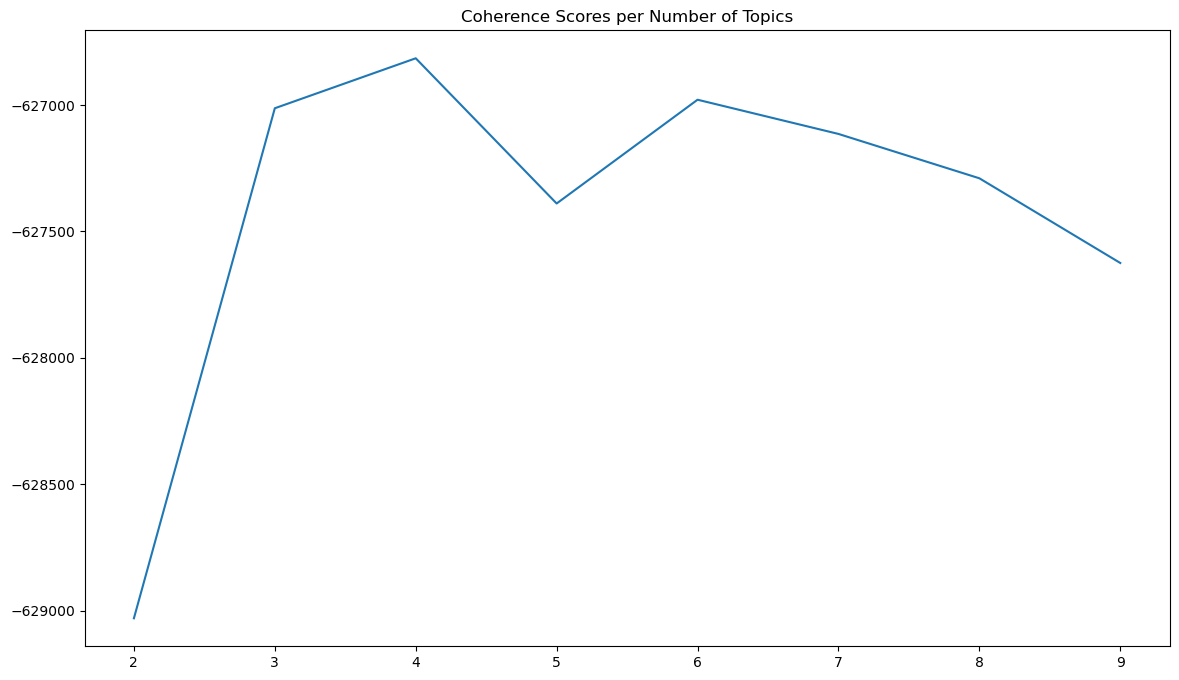

In [38]:
plt.figure(figsize=(14, 8))
plt.plot([x[0] for x in model_results], [x[1] for x in model_results])
plt.title("Coherence Scores per Number of Topics", size=12);

In [39]:
corpus_df

Text
British Gas    2017 Negative  claim read meter read charge hundred pound tak...
                    Neutral   engineer extremely knowledgeable fix boiler da...
                    Positive  need replacement boiler fit year old boiler co...
               2018 Negative  move home make mistake involve two month dare ...
                    Neutral   speak person quickly explain tariff option swi...
                    Positive  send engineer henry fix boiler problem thoroug...
               2019 Negative  homemade massive con leak upstairs bathroom co...
                    Positive  think good value money workman professional he...
               2020 Negative  touch homemade care annual service cancel lunc...
                    Neutral   month wait part unable answer call back numero...
                    Positive  engineer come today helpful nothing much troub...
               2021 Negative  shamble move zebra go bust nil information eg ...
                    Positive  electricity supply fine increase price website...
               2022 Negative  bad app customer support ever one ever online ...
                    Positive  wait several day engineer come fix heating tme...
               2023 Negative  since open account husband die unable open lin...
                    Neutral   charge customer different quote different memb...
                    Positive  call renew home service loyalty customer give ...
E.on           2022 Negative  one ever answer phone email tell anything act ...
                    Positive  four plus year smart meter able speak anyone q...
               2023 Negative  speak next give november reading enquire offer...
                    Positive  idea anyone would negative rate switch around ...
EDF Energy     2020 Negative  even respond complaint use third party respons...
                    Neutral   father pass away april even close account rece...
               2021 Negative  could write long list rude lie easy fart repea...
                    Neutral                 walk distance gym tomorrow night ex
                    Positive  omar adem absolutely brilliant patient kind th...
               2022 Negative  absolutely criminal actually rob scumbag chang...
                    Neutral   breaking point take supply without knowledge p...
                    Positive  karen complaint deal complaint quickly resolve...
               2023 Negative  total nightmare take month resolve issue non t...
                    Positive  awful customer service issue home display link...
Npower         2013 Negative  power really need stop send customer service s...
                    Positive  carole allison absolute asset power great cust...
               2015 Negative  awful company deal constantly thing wrong alwa...
               2016 Negative  bad company ever terrible experience never eve...
                    Positive  move property yesterday still electric ring po...
               2017 Negative  far bad customer service experience whole life...
               2018 Negative  stay away power try bill electric time live ho...
                    Neutral                             customer central worker
                    Positive  phone hour lady name karen say want say huge t...
               2019 Negative  use company staff totally incompetent charge e...
                    Positive  marie helpful advisor today call power erythem...
               2020 Negative  two appointment keep altogether hour waste tel...
                    Positive  take age talk anyone phone difficult understan...
               2021 Negative  charge power contract pay different company re...
Octopus Energy 2018 Negative  partner recently join bulb use another member ...
                    Positive  excellent utility company cheap bill tariff ch...
               2019 Negative  believe advert switch ovo sept already regret ...
                    Positive  happy price customer service green would reco

#### Using only Adjectives and Nouns

In [40]:
def nouns_adjects(text):
    "This will only get the nouns and adjectives"
    is_noun_adjective = lambda pos: pos[:2] == 'NN' or pos[:2] == 'JJ'

    tokens = word_tokenize(text.lower()) # tokenizing the word
    
    # Getting only the nouns and adjectives
    nouns_adj = [word for (word, pos) in pos_tag(tokens) if is_noun_adjective and len(word) > 1]
    return ' '.join(nouns_adj)

In [41]:
# Vectorizing adjectives and nouns
corpus_adj = corpus_df['Text'].apply(lambda x: nouns_adjects(x))

corpus_adj_noun = vectorize_text(corpus_adj)

In [42]:
# Getting the vocabulary
vocab_adj_noun = vectorizer.get_feature_names_out()

In [43]:
noun_adj_scores = []

for num in range(2, 10):
    noun_adj_scores.append(get_topic_words(num, 10, corpus_adj_noun))

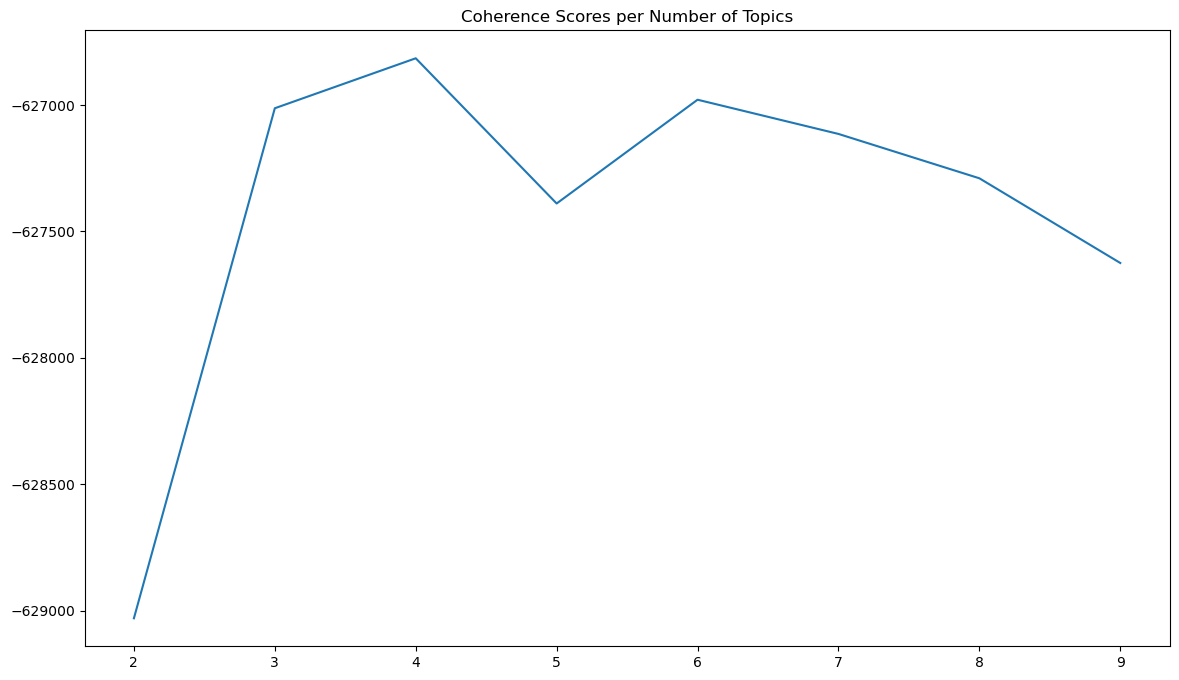

In [44]:
plt.figure(figsize=(14, 8))
plt.plot([x[0] for x in noun_adj_scores], [x[1] for x in noun_adj_scores])
plt.title("Coherence Scores per Number of Topics", size=12);

In [45]:
noun_adj_scores[1][2]

["Topic 1: ['bill' 'meter' 'company' 'month' 'customer' 'take' 'go' 'pay' 'account']",
 "Topic 2: ['service' 'call' 'engineer' 'customer' 'day' 'time' 'say' 'tell' 'phone']",
 "Topic 3: ['switch' 'credit' 'use' 'service' 'good' 'customer' 'account' 'tariff'\n 'month']"]

In [46]:
model_results[2][2]

["Topic 1: ['meter' 'bill' 'company' 'month' 'customer' 'take' 'go' 'pay' 'account']",
 "Topic 2: ['service' 'call' 'engineer' 'customer' 'day' 'time' 'say' 'tell' 'phone']",
 "Topic 3: ['switch' 'credit' 'use' 'service' 'good' 'customer' 'account' 'tariff'\n 'month']",
 "Topic 4: ['power' 'bill' 'meter' 'account' 'complaint' 'give' 'say' 'new' 'would']"]

In [47]:
# Most prevalent issues
Topic_1 = 'Complain and Service Resolution'
Topic_2 = 'Customer Service'
Topic_3 = "Billing and Meter Related Issues"

In [48]:
cleaned_data.head()

,Company,Reviewer Verification Status,Date,Rating,Review,Approximate Date of Review,Review_Text_Cleaned,Sentiment,year
0,British Gas,Verified Reviewer,6 years,1,they claimed to have read my meter and over re...,2017-12-01,claim read meter read charge hundred pound tak...,Negative,2017
1,British Gas,Not Verified,6 years,1,they have the worst communication between depa...,2017-12-01,bad communication department ever see book plu...,Negative,2017
2,British Gas,Verified Reviewer,6 years,1,worst customer service i have come across simp...,2017-12-01,bad customer service come across simply avoid ...,Negative,2017
3,British Gas,Not Verified,6 years,1,absolute shambles of a service for homemade bo...,2017-12-01,absolute shamble service homemade boiler cover...,Negative,2017
4,British Gas,Verified Reviewer,6 years,1,i pay a lot of money annually for homemade so ...,2017-12-01,pay lot money annually homemade peace mind cov...,Negative,2017


In [49]:
topic_proba = pd.DataFrame(model_results[1][-1], columns=['Topic 1', "Topic 2", "Topic 3"], index=corpus_df.index)

cleaned_data.rename(columns={'year': 'Year'}, inplace=True)
nps = {'British Gas': 5, 'E.on':5, 'EDF Energy':5, 'Npower':3, 'Octopus Energy':27}
cleaned_data['NPS'] = cleaned_data['Company'].apply(lambda x: nps[x])

# Resetting and renaming the index
topic_proba = topic_proba.reset_index().rename(columns={f"level_{ind}": val for ind, val in enumerate(['Company', 'Year', "Sentiment"])})

all_dataset = pd.merge(cleaned_data, topic_proba, on=['Company', 'Year', "Sentiment"], how='left')

In [50]:
tableau_word_cloud = all_dataset['Review_Text_Cleaned'].str.split(expand=True)

In [51]:
# Splitting the reviews dataset for tableau
null_vals_per_col = tableau_word_cloud.isnull().sum()

null_vals_per_col_idx = null_vals_per_col[null_vals_per_col > 3700].index

In [52]:
# Cleaning the dataset for tableau
tableau_word_cloud.drop(columns=null_vals_per_col_idx, inplace=True)

In [53]:
# Combining the datasets
all_dataset = pd.concat([all_dataset, tableau_word_cloud], axis=1)

In [54]:
# Removing the duplicated values
topic_indx = all_dataset[all_dataset.duplicated(['Company', 'Year', 'Sentiment', 'Topic 1', 'Topic 2', 'Topic 3'])].index

In [55]:
# Cleaning the dataset
for top in ['Topic 1', 'Topic 2', 'Topic 3']:
    all_dataset[top].loc[topic_indx] = None

C:\Users\USER\AppData\Local\Temp\ipykernel_13560\2823545767.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_dataset[top].loc[topic_indx] = None
C:\Users\USER\AppData\Local\Temp\ipykernel_13560\2823545767.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_dataset[top].loc[topic_indx] = None
C:\Users\USER\AppData\Local\Temp\ipykernel_13560\2823545767.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_dataset[top].loc[to

In [56]:
# Getting the duplicate of nps
nps_dupx = all_dataset[all_dataset.duplicated(['Company', 'NPS'])].index

all_dataset['NPS'].loc[nps_dupx] = None # cleaning the duplicate nps

C:\Users\USER\AppData\Local\Temp\ipykernel_13560\3339558180.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_dataset['NPS'].loc[nps_dupx] = None # cleaning the duplicate nps


In [57]:
# Removing other columns not needed
all_dataset.drop(columns=['Date', 'Review', 'Review_Text_Cleaned', 'Year'], inplace=True)

In [59]:
all_dataset.to_csv('all-dataset.csv', index=False) # Saving to csv